In [107]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.linalg import block_diag
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

In [88]:
# Soccer Environment
class Soccer:
    def __init__(self):
        # positions of player A and player B
        self.position = [np.array([0, 2]), np.array([0, 1])]
        self.ball = 1
        self.goal = [0, 3]

    def move(self, actions):
        # top-left corner as (0,0) origin point
        # 0:Up, 1:Right, 2:Down, 3:Left, 4:Stay
        # player can move at most one tile at a time
        # the index of actions map to movement at specific direction
        legal_actions = [[-1, 0], [0, 1], [1, 0], [0, -1], [0, 0]]

        # randomly select which player moves first
        # 0 is player A moves first, 1 is player B moves first
        mover_first = np.random.choice([0, 1], 1)[0]
        mover_second = 1 - mover_first

        # copy of current pos
        new_position = list(self.position)

        # scores shows the reward for player A and player B
        scores = np.array([0, 0])

        # init termination status of the game
        done = False

        # check whether the received action is valid
        if actions[0] not in range(0,5) or actions[1] not in range(0,5):
            print('Invalid Action, actions shall be in [0,1,2,3,4]')
            return [self.position[0][0] * 4 + self.position[0][1], self.position[1][0] * 4 + self.position[1][1], self.ball], scores, done
        else:
            # moving the first player
            new_position[mover_first] = self.position[mover_first] + legal_actions[actions[mover_first]]

            # check collision, 1st mover collides with 2nd mover after moving
            if (new_position[mover_first] == self.position[mover_second]).all():
                # if 1st mover possess ball, the ball is lost to 2nd mover
                if self.ball == mover_first:
                    self.ball = mover_second

            # no collision, update 1st mover's pos
            elif new_position[mover_first][0] in range(0,2) and new_position[mover_first][1] in range(0,4):
                self.position[mover_first] = new_position[mover_first]

                # if scored for player himself
                if self.position[mover_first][1] == self.goal[mover_first] and self.ball == mover_first:
                    return self.scored_self(mover_first)

                # if scored for the opponent
                elif self.position[mover_first][1] == self.goal[mover_second] and self.ball == mover_first:
                    return self.scored_opponent(mover_first)

            # moving the second player
            new_position[mover_second] = self.position[mover_second] + legal_actions[actions[mover_second]]

            # check collision, 2nd mover collides with 1st mover after moving
            if (new_position[mover_second] == self.position[mover_first]).all():  # Collide
                # if 2nd mover possess ball, the ball is lost to 1st mover
                if self.ball == mover_second:
                    self.ball = mover_first

            # no collision, update 2nd mover's pos
            elif new_position[mover_second][0] in range(0,2) and new_position[mover_second][1] in range(0,4):
                self.position[mover_second] = new_position[mover_second]

                # if scored for player himself
                if self.position[mover_second][1] == self.goal[mover_second] and self.ball == mover_second:
                    return self.scored_self(mover_second)

                # if scored for the opponent
                elif self.position[mover_second][1] == self.goal[mover_first] and self.ball == mover_second:
                    return self.scored_opponent(mover_second)

        return [self.position[0][0] * 4 + self.position[0][1], self.position[1][0] * 4 + self.position[1][1], self.ball], scores, done
      
    def scored_self(self,mover):
        scores = ([1, -1][mover]) * np.array([100, -100])
        done = True
        return [self.position[0][0] * 4 + self.position[0][1], self.position[1][0] * 4 + self.position[1][1], self.ball], scores, done
    
    def scored_opponent(self,mover):
        scores = np.array([-100, 100]) * [1, -1][mover]
        done = True
        return [self.position[0][0] * 4 + self.position[0][1], self.position[1][0] * 4 + self.position[1][1], self.ball], scores, done

    def reset(self):
        self.position = [np.array([0, 2]), np.array([0, 1])]
        self.ball = 1
        self.goal = [0, 3]

In [89]:
class solver:
    
    def __init__(self):
        self.env = Soccer()
        
        self.steps = int(1e6)
        
        self.gamma = 0.9
        # Define the epsilon and its decay for epsilon-greedy action selection
        self.epsilon = 1.0
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.999995

        # learning rate
        self.alpha = 1.0
        self.alpha_min = 0.001
        self.alpha_decay = 0.999995
    
    # Take action for Q and friend-Q method
    def generate_action(self, Q, state, epsilon,method):
        # epsilon-greey to take best action from action-value function
        if np.random.random() < epsilon:
            return np.random.choice([0,1,2,3,4], 1)[0]
        else:
            if method == "Q":
                return np.random.choice(np.where(Q[state[0]][state[1]][state[2]] == max(Q[state[0]][state[1]][state[2]]))[0], 1)[0]
            if method == "Friend-Q":
                max_action = np.where(Q[state[0]][state[1]][state[2]] == np.max(Q[state[0]][state[1]][state[2]]))
                return max_action[1][np.random.choice(range(len(max_action[0])), 1)[0]]
        print("Invalid Method")
        return
    
    def Q_learner(self):
        self.alpha = 1.0
        self.gamma = 0.9
        self.epsilon = 1.0
        error_list = []
        
        # Q_tables of player A and player B
        # the state-action space is 8 (pos for player A) * 8 (pos for player B) * 2 (ball possession) * 5 (valid actions)
        Q_1 = np.zeros((8, 8, 2, 5))
        Q_2 = np.zeros((8, 8, 2, 5))

        # index for step
        i = 0

        start_time = time.time()

        while i < self.steps:
            self.env.reset()

            # map two players positions and ball possession into state presentation
            state = [self.env.position[0][0] * 4 + self.env.position[0][1], self.env.position[1][0] * 4 + self.env.position[1][1], self.env.ball]

            while True:
                if i % 1000 == 0:
                    print('\rstep {}\t Time: {:.2f} \t Percentage: {:.2f}% \t Alpha: {:.3f}'.format(i, time.time() - start_time, i*100/self.steps, self.alpha), end="")

                # player A at sate S take action South before update
                # first index is player A's position index (0-7), 2 is frist row (0), 3rd column
                # second index is player B's position index (0-7), 1 is first row (0), 2nd column
                # third index is ball possession, according to graph, B has the ball
                # fourth index is action from player A, A is going south (2)
                before = Q_1[2][1][1][2]

                # eps-greedy to generate action
                actions = [self.generate_action(Q_1,state,self.epsilon,"Q"), self.generate_action(Q_2,state,self.epsilon,"Q")]
                # get next state, reward and game termination flag
                next_state, rewards, done = self.env.move(actions)

                i += 1

                # Q-learning for player A & B
                if done:
                    Q_1[state[0]][state[1]][state[2]][actions[0]] += self.alpha * (rewards[0] - Q_1[state[0]][state[1]][state[2]][actions[0]])

                    Q_2[state[0]][state[1]][state[2]][actions[1]] += self.alpha * (rewards[1] - Q_2[state[0]][state[1]][state[2]][actions[1]])

                    # player A at state S take action South before update
                    after = Q_1[2][1][1][2]
                    error_list.append(abs(after-before))
                    break

                else:
                    Q_1[state[0]][state[1]][state[2]][actions[0]] += self.alpha * (rewards[0] + self.gamma * max(Q_1[next_state[0]][next_state[1]][next_state[2]]) - Q_1[state[0]][state[1]][state[2]][actions[0]])

                    Q_2[state[0]][state[1]][state[2]][actions[1]] += self.alpha * (rewards[1] + self.gamma * max(Q_2[next_state[0]][next_state[1]][next_state[2]]) - Q_2[state[0]][state[1]][state[2]][actions[1]])
                    state = next_state

                    # player A at state S take action South before update
                    after = Q_1[2][1][1][2]
                    error_list.append(abs(after-before))

                #decay epsilon and alpha
                self.epsilon = max(self.epsilon_min, self.epsilon*self.epsilon_decay)

                self.alpha = max(self.alpha_min, self.alpha*self.alpha_decay)

        return error_list, Q_1, Q_2
    
    def Friend_Q(self):
        self.alpha = 1.0
        self.gamma = 0.9
        self.epsilon = 1.0
        error_list = []

        # Q_tables of player A and player B
        # the state-action space is 8 (pos for player A) * 8 (pos for player B) * 2 (ball possession) * 5 (valid actions for player A) * 5 (valid actions for player B)
        Q_1 = np.zeros((8, 8, 2, 5, 5))
        Q_2 = np.zeros((8, 8, 2, 5, 5))

        # index for step
        i = 0

        start_time = time.time()

        while i < self.steps:
            self.env.reset()

            # map two players positions and ball possession into state presentation
            state = [self.env.position[0][0] * 4 + self.env.position[0][1], self.env.position[1][0] * 4 + self.env.position[1][1], self.env.ball]

            while True:
                # if (i + 1) % 1000 == 0: print('\r', i + 1, ', Time lapse', time.time() - start_time, 'seconds for ', i*100/no_steps, "%", end = "")

                if i % 1000 == 0:
                    print('\rstep {}\t Time: {:.2f} \t Percentage: {:.2f}% \t Alpha: {:.3f}'.format(i, time.time() - start_time, i*100/self.steps, self.alpha), end="")

                # player A at sate S take action South before update
                # first index is player A's position index (0-7), 2 is frist row (0), 3rd column
                # second index is player B's position index (0-7), 1 is first row (0), 2nd column
                # third index is ball possession, according to graph, B has the ball
                # fourth index is action from player B, B sticks
                # fifth index is action from player A, A goes south
                # rationale for putting player A's action as last index is for easy handling of max function (put the last dimention as player's action rather than opponent's action)
                before = Q_1[2][1][1][4][2]

                # eps-greedy to generate action
                actions = [self.generate_action(Q_1,state,self.epsilon,"Friend-Q"), self.generate_action(Q_2,state,self.epsilon,"Friend-Q")]
                # get next state, reward and game termination flag
                next_state, rewards, done = self.env.move(actions)

                self.alpha = 1 / (i / self.alpha_min / self.steps + 1)

                i += 1

                # Friend-Q is Q-learning adding dimension of oppenent's action
                if done:
                    Q_1[state[0]][state[1]][state[2]][actions[1]][actions[0]] += self.alpha * (rewards[0] - Q_1[state[0]][state[1]][state[2]][actions[1]][actions[0]])

                    Q_2[state[0]][state[1]][state[2]][actions[0]][actions[1]] += self.alpha * (rewards[1] - Q_2[state[0]][state[1]][state[2]][actions[0]][actions[1]])

                    # player A at state S take action South before update
                    after = Q_1[2][1][1][4][2]
                    error_list.append(abs(after-before))
                    break

                else:
                    Q_1[state[0]][state[1]][state[2]][actions[1]][actions[0]] += self.alpha * (rewards[0] + self.gamma * np.max(Q_1[next_state[0]][next_state[1]][next_state[2]]) - Q_1[state[0]][state[1]][state[2]][actions[1]][actions[0]])

                    Q_2[state[0]][state[1]][state[2]][actions[0]][actions[1]] += self.alpha * (rewards[1] + self.gamma * np.max(Q_2[next_state[0]][next_state[1]][next_state[2]]) - Q_2[state[0]][state[1]][state[2]][actions[0]][actions[1]])
                    state = next_state

                    # player A at state S take action South before update
                    after = Q_1[2][1][1][4][2]
                    error_list.append(abs(after-before))

                self.epsilon = max(self.epsilon_min, self.epsilon*self.epsilon_decay)

        return error_list, Q_1, Q_2
    
    #Take action for Foe-Q and CE-Q methods
    def next_action(self,pi, state, i,method):
        self.epsilon = self.epsilon_decay ** i
        if np.random.random() < self.epsilon:
            if method == "Foe-Q":
                return np.random.choice([0,1,2,3,4], 1)[0]
            if method == "CE-Q":
                index = np.random.choice(np.arange(25), 1)
                return np.array([index // 5, index % 5]).reshape(2)
        else:
            if method == "Foe-Q":
                return np.random.choice([0,1,2,3,4], 1, p=pi[state[0]][state[1]][state[2]])[0]
            if method == "CE-Q":
                index = np.random.choice(np.arange(25), 1, p=pi[state[0]][state[1]][state[2]].reshape(25))
                return np.array([index // 5, index % 5]).reshape(2)
        
        print("Invalid Method")
        return
    
    def max_min(self, Q, state):
        c = matrix([-1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        G = matrix(np.append(np.append(np.ones((5,1)), -Q[state[0]][state[1]][state[2]], axis=1), np.append(np.zeros((5,1)), -np.eye(5), axis=1), axis=0))
        h = matrix([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        A = matrix([[0.0],[1.0], [1.0], [1.0], [1.0], [1.0]])
        b = matrix(1.0)
        sol = solvers.lp(c=c, G=G, h=h, A=A, b=b)
        return np.abs(sol['x'][1:]).reshape((5,)) / sum(np.abs(sol['x'][1:])), np.array(sol['x'][0])
    
    def Foe_Q(self):
        self.gamma = 0.9
        error_list = []
        self.epsilon_decay = 10**(np.log10(self.epsilon_min)/self.steps)

        # learning rate
        self.alpha_decay = 10**(np.log10(self.alpha_min)/self.steps)

        # Q_tables of player A and player B
        # the state-action space is 8 (pos for player A) * 8 (pos for player B) * 2 (ball possession) * 5 (valid actions for player A) * 5 (valid actions for player B)
        # initialization to 1 in order to break from zero
        Q_1 = np.ones((8, 8, 2, 5, 5)) * 1.0
        Q_2 = np.ones((8, 8, 2, 5, 5)) * 1.0

        # init policy for player 1 and player 2
        Pi_1 = np.ones((8, 8, 2, 5)) * 1/5
        Pi_2 = np.ones((8, 8, 2, 5)) * 1/5

        # value of states, only depends on pos of players and possession of ball
        V_1 = np.ones((8, 8, 2)) * 1.0
        V_2 = np.ones((8, 8, 2)) * 1.0
        
        start_time = time.time()
        i = 0

        while i < self.steps:
            self.env.reset()
            state = [self.env.position[0][0] * 4 + self.env.position[0][1], self.env.position[1][0] * 4 + self.env.position[1][1], self.env.ball]
            done = 0
            while not done:
                if i % 1000 == 0:
                    print('\rstep {}\t Time: {:.2f} \t Percentage: {:.2f}% \t Alpha: {:.3f}'.format(i, time.time() - start_time, i*100/self.steps, self.alpha), end="")
                i += 1

                # player A at sate S take action South before update
                # first index is player A's position index (0-7), 2 is frist row (0), 3rd column
                # second index is player B's position index (0-7), 1 is first row (0), 2nd column
                # third index is ball possession, according to graph, B has the ball
                # fourth index is action from player B, B sticks
                # fifth index is action from player A, A goes south
                # rationale for putting player A's action as last index is for easy handling of max function (put the last dimention as player's action rather than opponent's action)
                before = Q_1[2][1][1][4][2]

                # eps-greedy to generate action
                actions = [self.next_action(Pi_1, state, i,"Foe-Q"), self.next_action(Pi_2, state, i,"Foe-Q")]

                # get next state, reward and game termination flag
                next_state, rewards, done = self.env.move(actions)

                # Q-learning update
                Q_1[state[0]][state[1]][state[2]][actions[1]][actions[0]] = (1 - self.alpha) * Q_1[state[0]][state[1]][state[2]][actions[1]][actions[0]] + self.alpha * (rewards[0] + self.gamma * V_1[next_state[0]][next_state[1]][next_state[2]])

                # use LP to solve maxmin
                pi, val = self.max_min(Q_1, state)
                Pi_1[state[0]][state[1]][state[2]] = pi
                V_1[state[0]][state[1]][state[2]] = val

                # Q-learning update
                Q_2[state[0]][state[1]][state[2]][actions[0]][actions[1]] = (1 - self.alpha) * Q_2[state[0]][state[1]][state[2]][actions[0]][actions[1]] + self.alpha * (rewards[1] + self.gamma * V_2[next_state[0]][next_state[1]][next_state[2]])

                # use LP to solve maxmin
                pi, val = self.max_min(Q_2, state)
                Pi_2[state[0]][state[1]][state[2]] = pi
                V_2[state[0]][state[1]][state[2]] = val
                state = next_state

                # compute ERR
                after = Q_1[2][1][1][4][2]
                error_list.append(np.abs(after - before))

                # decay learning rate
                self.alpha = self.alpha_decay ** i

        return error_list, Q_1, Q_2, V_1, V_2, Pi_1, Pi_2
    
    # using LP to solve correlated-equilibrium
    def solve_ce(self, Q_1, Q_2, state):
        # subset the condition for player A
        Q_states = Q_1[state[0]][state[1]][state[2]]
        s = block_diag(Q_states - Q_states[0, :], Q_states - Q_states[1, :], Q_states - Q_states[2, :], Q_states - Q_states[3, :], Q_states - Q_states[4, :])
        row_index = [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23]
        parameters_1 = s[row_index, :]

        # subset the condition for player B
        Q_states = Q_2[state[0]][state[1]][state[2]]
        s = block_diag(Q_states - Q_states[0, :], Q_states - Q_states[1, :], Q_states - Q_states[2, :], Q_states - Q_states[3, :], Q_states - Q_states[4, :])
        col_index = [0, 5, 10, 15, 20, 1, 6, 11, 16, 21, 2, 7, 12, 17, 22, 3, 8, 13, 18, 23, 4, 9, 14, 19, 24]
        parameters_2 = s[row_index, :][:, col_index]

        c = matrix((Q_1[state[0]][state[1]][state[2]] + Q_2[state[0]][state[1]][state[2]].T).reshape(25))
        # construct rationality constraints
        G = matrix(np.append(np.append(parameters_1, parameters_2, axis=0), -np.eye(25), axis=0))
        h = matrix(np.zeros(65) * 0.0)
        # construct probability constraints
        A = matrix(np.ones((1, 25)))
        b = matrix(1.0)

        # error-handling mechanism
        try:
            sol = solvers.lp(c=c, G=G, h=h, A=A, b=b)
            if sol['x'] is not None:
                prob = np.abs(np.array(sol['x']).reshape((5, 5))) / sum(np.abs(sol['x']))
                val_1 = np.sum(prob * Q_1[state[0]][state[1]][state[2]])
                val_2 = np.sum(prob * Q_2[state[0]][state[1]][state[2]].T)
            else:
                prob = None
                val_1 = None
                val_2 = None
        except:
            print("error!!")
            prob = None
            val_1 = None
            val_2 = None

        return prob, val_1, val_2
    
    def CE_Q(self):
        self.gamma = 0.9
        self.epsilon_decay = 10 ** (np.log10(self.epsilon_min)/self.steps)

        self.alpha_decay = 10 ** (np.log10(self.alpha_min)/self.steps)

        # Q_tables of player A and player B
        # the state-action space is 8 (pos for player A) * 8 (pos for player B) * 2 (ball possession) * 5 (valid actions for player A) * 5 (valid actions for player B)
        Q_1 = np.ones((8, 8, 2, 5, 5)) * 1.0
        Q_2 = np.ones((8, 8, 2, 5, 5)) * 1.0

        # value of states, only depends on pos of players and possession of ball
        V_1 = np.ones((8, 8, 2)) * 1.0
        V_2 = np.ones((8, 8, 2)) * 1.0

        # shared joint policy
        Pi = np.ones((8, 8, 2, 5, 5)) * 1/25

        # error list to store ERR
        error_list = []

        start_time = time.time()
        i = 0
        while i < self.steps:
            self.env.reset()
            state = [self.env.position[0][0] * 4 + self.env.position[0][1], self.env.position[1][0] * 4 + self.env.position[1][1], self.env.ball]
            done = 0
            j = 0
            while not done and j <= 100:
                if i % 1000 == 0 and i > 1:
                    print('\rstep {}\t Time: {:.2f} \t Percentage: {:.2f}% \t Alpha: {:.3f}'.format(i, time.time() - start_time, i*100/self.steps, self.alpha), end="")

                # udpate index
                i += 1
                j += 1

                # we don't need place player B action space before player A
                # since we are no longer just selecting the max of player A
                before = Q_1[2][1][1][2][4]

                # eps-greedy to generate action
                actions = self.next_action(Pi, state, i,"CE-Q")

                next_state, rewards, done = self.env.move(actions)
                self.alpha = self.alpha_decay ** i

                # Q-learning update
                Q_1[state[0]][state[1]][state[2]][actions[0]][actions[1]] = (1 - self.alpha) * Q_1[state[0]][state[1]][state[2]][actions[0]][actions[1]] + self.alpha * (rewards[0] + self.gamma * V_1[next_state[0]][next_state[1]][next_state[2]])

                # Q-learning update
                Q_2[state[0]][state[1]][state[2]][actions[1]][actions[0]] = (1 - self.alpha) * Q_2[state[0]][state[1]][state[2]][actions[1]][actions[0]] + self.alpha * (rewards[1] + self.gamma * V_2[next_state[0]][next_state[1]][next_state[2]].T)
                prob, val_1, val_2 = self.solve_ce(Q_1, Q_2, state)

                # update only if not Null returned from the ce solver
                if prob is not None:
                    Pi[state[0]][state[1]][state[2]] = prob
                    V_1[state[0]][state[1]][state[2]] = val_1
                    V_2[state[0]][state[1]][state[2]] = val_2
                state = next_state

                # player A at state S take action South after update
                after = Q_1[2][1][1][2][4]
                # compute the error
                error_list.append(np.abs(after - before))

        return error_list, Q_1, Q_2, V_1, V_2, Pi



In [104]:
agent = solver()

In [105]:
#agent = solver()
q_learning_errors, Q_1_qlearning, Q_2_qlearning = agent.Q_learner()

step 1000000	 Time: 135.03 	 Percentage: 100.00% 	 Alpha: 0.011

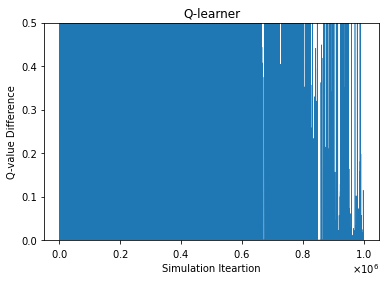

In [106]:
plt.plot(np.array(q_learning_errors), linestyle='-', linewidth=0.6)
plt.title('Q-learner')
plt.ylim(0, 0.5)
plt.xlabel('Simulation Iteartion')
plt.ylabel('Q-value Difference')
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0), useMathText=True)
plt.show()

In [102]:
#agent = solver()
friend_q_errors, Q_1_friend, Q_2_friend = agent.Friend_Q()

step 1000000	 Time: 171.72 	 Percentage: 100.00% 	 Alpha: 0.001

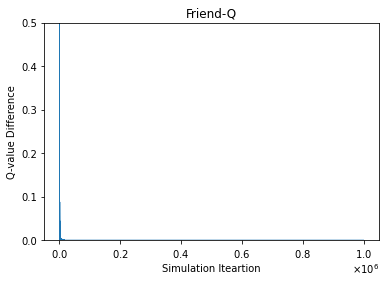

In [103]:
plt.plot(np.array(friend_q_errors), linestyle='-', linewidth=0.6)
plt.title('Friend-Q')
plt.ylim(0, 0.5)
plt.xlabel('Simulation Iteartion')
plt.ylabel('Q-value Difference')
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0), useMathText=True)
plt.show()

In [95]:
#agent = solver()
foe_q_errors, Q_1_foe, Q_2_foe, V_1_foe, V_2_foe, Pi_1_foe, Pi_2_foe = agent.Foe_Q()

step 1000000	 Time: 3350.41 	 Percentage: 100.00% 	 Alpha: 0.001

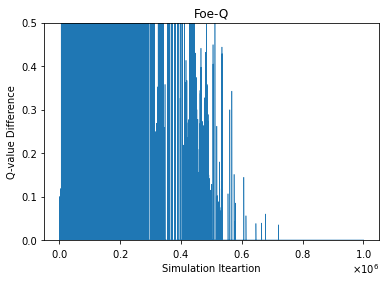

In [96]:
plt.plot(np.array(foe_q_errors), linestyle='-', linewidth=0.6)
plt.title('Foe-Q')
plt.ylim(0, 0.5)
plt.xlabel('Simulation Iteartion')
plt.ylabel('Q-value Difference')
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0), useMathText=True)
plt.show()

In [97]:
#agent = solver()
ce_q_errors, Q_1_ce, Q_2_ce, V_1_ce, V_2_ce, Pi_ce = agent.CE_Q()

step 835000	 Time: 12925.26 	 Percentage: 83.50% 	 Alpha: 0.003error!!
step 1000000	 Time: 13545.47 	 Percentage: 100.00% 	 Alpha: 0.001

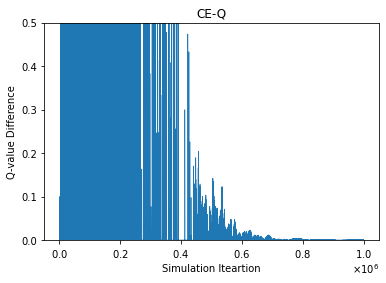

In [98]:
plt.plot(np.array(ce_q_errors), linestyle='-', linewidth=0.6)
plt.title('CE-Q')
plt.ylim(0, 0.5)
plt.xlabel('Simulation Iteartion')
plt.ylabel('Q-value Difference')
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0), useMathText=True)
plt.show()